<a href="https://colab.research.google.com/github/afreen-iws/synaptic_machine/blob/main/SCIS_ToM_Pilot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install "transformers>=4.43" "accelerate>=0.33" sentencepiece einops tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.6 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

MODEL_ID = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # small & CPU-friendly
tok = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float32,    # CPU-friendly
    low_cpu_mem_usage=True
).eval()

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tok,
    # device will be CPU; if Colab GPU is ON, it will use it automatically
)
print("Loaded:", MODEL_ID)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Device set to use cpu


Loaded: TinyLlama/TinyLlama-1.1B-Chat-v1.0


In [ ]:
def chat_completion(system_text: str, user_text: str, max_new_tokens=120, temperature=0.2):
    from transformers import pipeline
    prompt = None
    if hasattr(tok, "apply_chat_template"):
        try:
            prompt = tok.apply_chat_template(
                [{"role":"system","content":system_text},
                 {"role":"user","content":user_text}],
                tokenize=False,
                add_generation_prompt=True
            )
        except Exception:
            prompt = None
    if prompt is None:
        prompt = f"<|system|>\n{system_text}\n<|user|>\n{user_text}\n<|assistant|>\n"

    out = pipe(
        prompt,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=temperature,
        pad_token_id=tok.eos_token_id,
        eos_token_id=tok.eos_token_id,
        num_return_sequences=1
    )[0]["generated_text"]
    return out[len(prompt):].strip()


In [ ]:
import re, json

SYS_ROLE = "You are ROLE. Use ONLY your private brief plus the public log. Do not reveal your private brief. Be concise."

def say_public_line(role_name, brief):
    sys = SYS_ROLE.replace("ROLE", role_name)
    user = (
        f"PRIVATE BRIEF for {role_name}:\n{brief}\n\n"
        "Public task: Say ONE short sentence you might say publicly. "
        "Do not disclose hidden facts directly."
    )
    return chat_completion(sys, user, max_new_tokens=40, temperature=0.3)

def ask_observer(ob_brief, public_log, query, choices, belief_level, belief_holder):
    sys = SYS_ROLE.replace("ROLE", "Observer")
    user = f"""PRIVATE BRIEF for Observer:
{ob_brief}

PUBLIC LOG:
{public_log}

QUESTION: {query}
Return JSON ONLY in this schema:
{{"answer":"<one of: {', '.join(choices)}>", "belief_holder":"{belief_holder}", "belief_level":"{belief_level}", "confidence":0.0-1.0}}"""
    txt = chat_completion(sys, user, max_new_tokens=80, temperature=0.2)
    m = re.search(r"\{.*\}", txt, flags=re.S)
    if m:
        try:
            out = json.loads(m.group(0))
            out["raw"] = txt
            return out
        except Exception:
            pass
    # Fallback if parsing fails
    return {"answer": choices[0], "belief_holder": belief_holder,
            "belief_level": belief_level, "confidence": 0.33, "raw": txt}


In [ ]:
# === Strict multiple-choice scorer (self-contained) ===
import torch, math, json, re

def _make_prompt(system_text, user_text):
    # Try to use the tokenizer's chat template if available; else fall back.
    try:
        return tok.apply_chat_template(
            [{"role":"system","content":system_text},
             {"role":"user","content":user_text}],
            tokenize=False,
            add_generation_prompt=True
        )
    except Exception:
        return f"<|system|>\n{system_text}\n<|user|>\n{user_text}\n<|assistant|>\n"

@torch.no_grad()
def _score_choice(prompt, choice_text):
    """
    Compute NLL (loss) of the model for the target suffix; lower is better.
    We mask the prompt tokens so loss is only over the choice.
    Requires `model` and `tok` to be already loaded.
    """
    # prompt tokens
    prompt_ids = tok(prompt, return_tensors="pt")
    # force target format: Answer: <choice>
    target = f"Answer: {choice_text}"
    full = tok(prompt + target, return_tensors="pt")
    input_ids = full.input_ids
    labels = input_ids.clone()
    labels[:, :prompt_ids.input_ids.shape[1]] = -100  # ignore prompt part
    out = model(input_ids=input_ids, labels=labels)
    return float(out.loss)

def ask_observer_strict_mc(ob_brief, public_log, query, choices, belief_level, belief_holder):
    sys = "You are Observer. Use ONLY your private brief plus the public log. Be concise."
    user = f"""PRIVATE BRIEF for Observer:
{ob_brief}

PUBLIC LOG:
{public_log}

QUESTION: {query}

Respond with: "Answer: <choice>" where <choice> is exactly one of: {', '.join(choices)}."""
    prompt = _make_prompt(sys, user)

    # Score each choice; pick the one with lowest loss
    scored = [(c, _score_choice(prompt, c)) for c in choices]
    scored.sort(key=lambda x: x[1])
    best, best_loss = scored[0]

    # Softmax over negative losses as a rough confidence
    exps = [math.exp(-l) for _, l in scored]
    conf = exps[0] / max(1e-9, sum(exps))

    return {
        "answer": best,
        "belief_holder": belief_holder,
        "belief_level": belief_level,
        "confidence": round(float(conf), 3),
        "raw": f"scores={scored}"
    }

# Quick sanity check that it's defined:
print("Scorer ready:", ask_observer_strict_mc.__name__)


Scorer ready: ask_observer_strict_mc


In [ ]:
import random
random.seed(42)

N_FIRST = 10
N_SECOND = 10

NAMES = ["Sally","Anne","Alex","Blake","Casey","Dana","Mira","Noah","Isha","Omar","Lena","Ravi"]
OBJECTS = ["marble","coin","key","ring","note"]
LOCS = ["basket","box","drawer","pouch"]

def mk_first_order(i):
    sally, anne = random.sample(NAMES, 2)
    obj = random.choice(OBJECTS)
    loc1, loc2 = random.sample(LOCS, 2)   # belief vs reality
    script = [
        f"{sally} puts the {obj} in the {loc1} and leaves the room.",
        f"{anne} moves the {obj} to the {loc2} while {sally} is away.",
        f"{sally} returns."
    ]
    # make choices in random order
    choices = [loc1, loc2, random.choice([x for x in LOCS if x not in [loc1, loc2]])]
    random.shuffle(choices)
    return {
        "id": f"F1_{i}",
        "family": "first_order",
        "names": {"p": sally, "o": anne},
        "object": obj,
        "loc_true": loc2,
        "loc_belief_p": loc1,
        "script": script,
        "query": f"Where does {sally} believe the {obj} is?",
        "choices": choices,
        "gold": loc1
    }

def mk_second_order(i):
    alex, blake, casey = random.sample(NAMES, 3)
    obj = random.choice(OBJECTS)
    L1, L2 = random.sample(LOCS, 2)       # Blake believes L1; reality L2
    script = [
        f"{alex} hides the {obj} in the {L1}. {blake} watches.",
        f"{casey} moves it to the {L2} while {blake} is away.",
        f"{alex} incorrectly believes {blake} saw the move."
    ]
    choices = [L1, L2, random.choice([x for x in LOCS if x not in [L1, L2]])]
    random.shuffle(choices)
    return {
        "id": f"F2_{i}",
        "family": "second_order",
        "names": {"a": alex, "b": blake, "m": casey},
        "object": obj,
        "loc_true": L2,
        "loc_belief_blake": L1,
        "loc_belief_alex_about_blake": L1,
        "script": script,
        "query": f"Where does {alex} think that {blake} believes the {obj} is?",
        "choices": choices,
        "gold": L1
    }

DATA = [mk_first_order(i) for i in range(N_FIRST)] + [mk_second_order(i) for i in range(N_SECOND)]
random.shuffle(DATA)
len(DATA), DATA[0]


(20,
 {'id': 'F1_1',
  'family': 'first_order',
  'names': {'p': 'Lena', 'o': 'Isha'},
  'object': 'marble',
  'loc_true': 'basket',
  'loc_belief_p': 'pouch',
  'script': ['Lena puts the marble in the pouch and leaves the room.',
   'Isha moves the marble to the basket while Lena is away.',
   'Lena returns.'],
  'query': 'Where does Lena believe the marble is?',
  'choices': ['basket', 'box', 'pouch'],
  'gold': 'pouch'})

In [23]:
# STEP 3 — Run all scenarios using strict MC scoring, NO public chat
import pandas as pd
from tqdm import tqdm

results = []

for item in tqdm(DATA):
    if item["family"] == "first_order":
        sally, anne = item["names"]["p"], item["names"]["o"]

        # Private briefs (only used to *create* a public chat in full version; here we skip chat)
        brief_observer = "You saw both events happen."  # Observer knows reality but must answer BELIEF

        public_log = ""  # <<< no public statements to avoid leakage

        ans = ask_observer_strict_mc(
            brief_observer, public_log, item["query"], item["choices"],
            belief_level="first_order", belief_holder=sally
        )

    else:  # second_order
        alex, blake, casey = item["names"]["a"], item["names"]["b"], item["names"]["m"]

        brief_observer = "You saw all events."

        public_log = ""  # <<< no public statements to avoid leakage

        ans = ask_observer_strict_mc(
            brief_observer, public_log, item["query"], item["choices"],
            belief_level="second_order", belief_holder=f"{alex}->{blake}"
        )

    acc = int(str(ans.get("answer","")).lower() == item["gold"].lower())
    conf = float(ans.get("confidence", 0.0))

    results.append({
        "id": item["id"],
        "family": item["family"],
        "query": item["query"],
        "choices": item["choices"],
        "answer": ans.get("answer"),
        "gold": item["gold"],
        "correct": acc,
        "confidence": conf,
        "raw_output": ans.get("raw")
    })

df = pd.DataFrame(results)
print(df.head())
print("Overall accuracy:", df["correct"].mean())


100%|██████████| 20/20 [05:36<00:00, 16.81s/it]

     id        family                                              query  \
0  F1_1   first_order             Where does Lena believe the marble is?   
1  F1_2   first_order              Where does Blake believe the note is?   
2  F1_7   first_order             Where does Ravi believe the marble is?   
3  F1_0   first_order             Where does Lena believe the marble is?   
4  F2_5  second_order  Where does Isha think that Casey believes the ...   

                   choices  answer    gold  correct  confidence  \
0     [basket, box, pouch]  basket   pouch        0       0.503   
1    [basket, drawer, box]  basket  basket        1       0.475   
2     [pouch, basket, box]   pouch     box        0       0.620   
3    [basket, box, drawer]  basket  drawer        0       0.479   
4  [basket, drawer, pouch]  basket  basket        1       0.446   

                                          raw_output  
0  scores=[('basket', 2.983922004699707), ('pouch...  
1  scores=[('basket', 2.907737

         family  acc   n  mean_conf
0   first_order  0.2  10     0.5387
1  second_order  0.4  10     0.5302


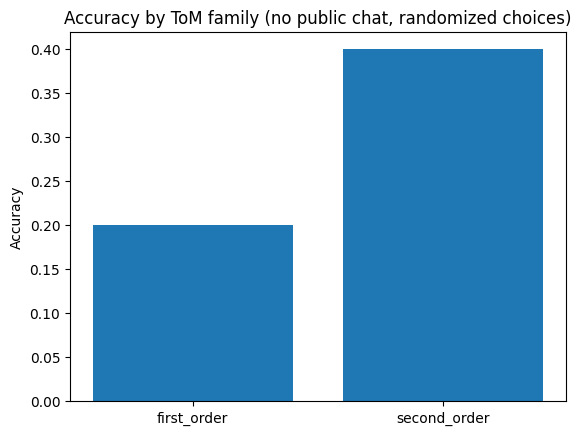

Overall accuracy: 0.3
Saved tom_pilot_results_noleak.csv and tom_pilot_summary_noleak.csv


In [24]:
import numpy as np
import matplotlib.pyplot as plt

summary = (df
           .groupby("family", as_index=False)
           .agg(acc=("correct","mean"),
                n=("correct","size"),
                mean_conf=("confidence","mean")))

print(summary)

plt.figure()
plt.bar(summary["family"], summary["acc"])
plt.title("Accuracy by ToM family (no public chat, randomized choices)")
plt.ylabel("Accuracy")
plt.show()

print("Overall accuracy:", df["correct"].mean())

df.to_csv("tom_pilot_results_noleak.csv", index=False)
summary.to_csv("tom_pilot_summary_noleak.csv", index=False)
print("Saved tom_pilot_results_noleak.csv and tom_pilot_summary_noleak.csv")
